# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/train",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/valid",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7335 files belonging to 4 classes.
==========================Validation Data====================
Found 1825 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/grape/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/grape/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7335 images belonging to 4 classes.
Found 1825 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Tue May 30 20:37:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P0               30W /  N/A|   4804MiB /  6144MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Augmentation

## DenseNet Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_DenseNet_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_________________________________________

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.9110
Epoch 1: val_accuracy improved from -inf to 0.91014, saving model to Grape_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


367/367 [==============================] - 131s 305ms/step - loss: 0.4621 - accuracy: 0.9110 - val_loss: 0.4280 - val_accuracy: 0.9101 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9629
Epoch 2: val_accuracy improved from 0.91014 to 0.96712, saving model to Grape_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


367/367 [==============================] - 107s 290ms/step - loss: 0.1195 - accuracy: 0.9629 - val_loss: 0.0995 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9692
Epoch 3: val_accuracy did not improve from 0.96712
367/367 [==============================] - 70s 189ms/step - loss: 0.1062 - accuracy: 0.9692 - val_loss: 0.3642 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9745
Epoch 4: val_accuracy did not improve from 0.96712
367/367 [==============================] - 70s 190ms/step - loss: 0.0940 - accuracy: 0.9745 - val_loss: 0.7358 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9738
Epoch 5: val_accuracy improved from 0.96712 to 0.96877, saving model to Grape_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


367/367 [==============================] - 109s 297ms/step - loss: 0.0814 - accuracy: 0.9738 - val_loss: 0.0854 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9835
Epoch 6: val_accuracy improved from 0.96877 to 0.99452, saving model to Grape_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


367/367 [==============================] - 109s 295ms/step - loss: 0.0528 - accuracy: 0.9835 - val_loss: 0.0199 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9832
Epoch 7: val_accuracy did not improve from 0.99452
367/367 [==============================] - 70s 190ms/step - loss: 0.0564 - accuracy: 0.9832 - val_loss: 0.5485 - val_accuracy: 0.9129 - lr: 0.0010
Epoch 8/100
367/367 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9791
Epoch 8: val_accuracy did not improve from 0.99452
367/367 [==============================] - 71s 193ms/step - loss: 0.0662 - accuracy: 0.9791 - val_loss: 0.0470 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 9/100
367/367 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9825
Epoch 9: val_accuracy did not improve from 0.99452
367/367 [==============================] - 71s 193ms/step - loss: 0.0641 - accuracy: 0.9825 - val_loss: 0.2876 - v

INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


367/367 [==============================] - 109s 298ms/step - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.0080 - val_accuracy: 0.9973 - lr: 1.0000e-04
Epoch 13/100
367/367 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9956
Epoch 13: val_accuracy improved from 0.99726 to 0.99836, saving model to Grape_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


367/367 [==============================] - 109s 297ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0057 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9959
Epoch 14: val_accuracy did not improve from 0.99836
367/367 [==============================] - 71s 193ms/step - loss: 0.0108 - accuracy: 0.9959 - val_loss: 0.0053 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 15/100
367/367 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9971
Epoch 15: val_accuracy did not improve from 0.99836
367/367 [==============================] - 76s 206ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.0084 - val_accuracy: 0.9967 - lr: 1.0000e-04
Epoch 16/100
367/367 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9967
Epoch 16: val_accuracy improved from 0.99836 to 0.99890, saving model to Grape_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model1_Based_Augmented\assets


367/367 [==============================] - 110s 300ms/step - loss: 0.0094 - accuracy: 0.9967 - val_loss: 0.0039 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 17/100
367/367 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9977
Epoch 17: val_accuracy did not improve from 0.99890
367/367 [==============================] - 74s 199ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 0.0043 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 18/100
367/367 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9982
Epoch 18: val_accuracy did not improve from 0.99890
367/367 [==============================] - 77s 208ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0038 - val_accuracy: 0.9973 - lr: 1.0000e-04
Epoch 19/100
367/367 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9982
Epoch 19: val_accuracy did not improve from 0.99890
367/367 [==============================] - 77s 210ms/step - loss: 0.0068 - accuracy: 0.9982 - va

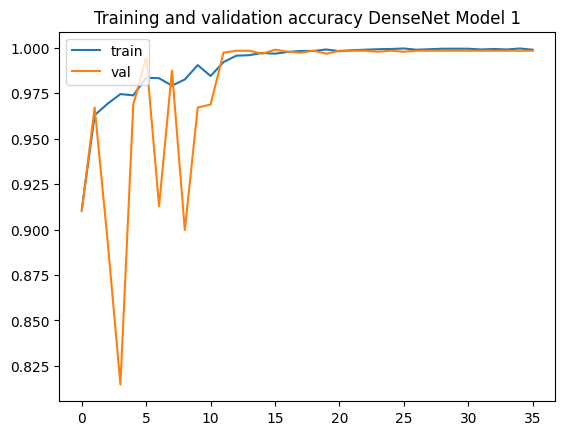

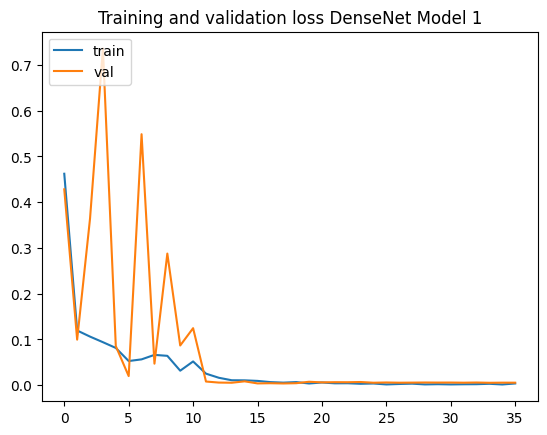

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DenseNet Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_DenseNet_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_______________________________________

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9376
Epoch 1: val_accuracy improved from -inf to 0.96712, saving model to Grape_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


367/367 [==============================] - 135s 338ms/step - loss: 0.1959 - accuracy: 0.9376 - val_loss: 0.2100 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9558
Epoch 2: val_accuracy improved from 0.96712 to 0.97808, saving model to Grape_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


367/367 [==============================] - 122s 330ms/step - loss: 0.1319 - accuracy: 0.9558 - val_loss: 0.0801 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9766
Epoch 3: val_accuracy improved from 0.97808 to 0.99068, saving model to Grape_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


367/367 [==============================] - 126s 343ms/step - loss: 0.0727 - accuracy: 0.9766 - val_loss: 0.0264 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9843
Epoch 4: val_accuracy improved from 0.99068 to 0.99507, saving model to Grape_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


367/367 [==============================] - 127s 344ms/step - loss: 0.0433 - accuracy: 0.9843 - val_loss: 0.0218 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9815
Epoch 5: val_accuracy did not improve from 0.99507
367/367 [==============================] - 89s 240ms/step - loss: 0.0567 - accuracy: 0.9815 - val_loss: 0.2316 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9760
Epoch 6: val_accuracy did not improve from 0.99507
367/367 [==============================] - 92s 251ms/step - loss: 0.0756 - accuracy: 0.9760 - val_loss: 0.0754 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9869
Epoch 7: val_accuracy did not improve from 0.99507
367/367 [==============================] - 93s 254ms/step - loss: 0.0472 - accuracy: 0.9869 - val_loss: 0.5283 - v

INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


367/367 [==============================] - 130s 354ms/step - loss: 0.0178 - accuracy: 0.9950 - val_loss: 0.0074 - val_accuracy: 0.9956 - lr: 1.0000e-04
Epoch 11/100
367/367 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9969
Epoch 11: val_accuracy improved from 0.99562 to 0.99616, saving model to Grape_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


367/367 [==============================] - 131s 357ms/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.0056 - val_accuracy: 0.9962 - lr: 1.0000e-04
Epoch 12/100
367/367 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9975
Epoch 12: val_accuracy improved from 0.99616 to 1.00000, saving model to Grape_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DenseNet_model2_Based_Augmented\assets


367/367 [==============================] - 129s 352ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0028 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 13/100
367/367 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9971
Epoch 13: val_accuracy did not improve from 1.00000
367/367 [==============================] - 89s 242ms/step - loss: 0.0096 - accuracy: 0.9971 - val_loss: 0.0107 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9993
Epoch 14: val_accuracy did not improve from 1.00000
367/367 [==============================] - 88s 240ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0049 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 15/100
367/367 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 15: val_accuracy did not improve from 1.00000
367/367 [==============================] - 91s 246ms/step - loss: 0.0051 - accuracy: 0.9981 - va

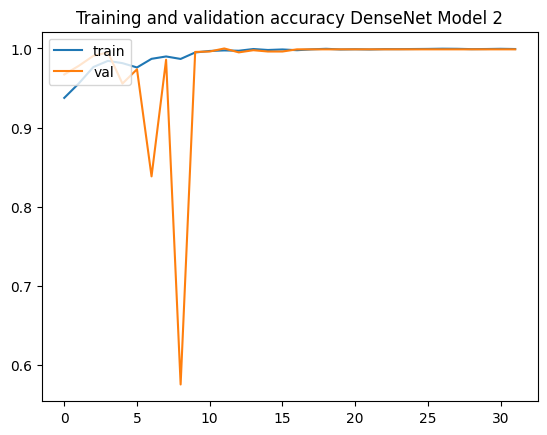

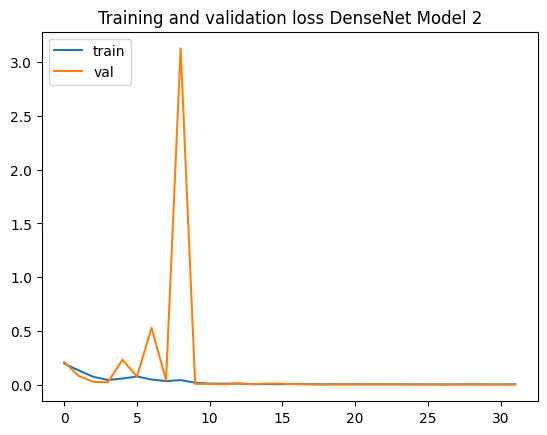

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')